In [3]:
#@title Код для ejudge
import numpy as np
import scipy as sp
# from time import time
from scipy.signal import fftconvolve as conv
from scipy.special import logsumexp
from scipy import linalg
from tqdm import tqdm


def d_argmax(p):
    max_idx = p.reshape(-1, p.shape[2]).argmax(0)
    x = np.column_stack(np.unravel_index(max_idx, p[:, :, 0].shape))
    x = np.swapaxes(x, axis1=0, axis2=1)
    return x


def calculate_log_probability(X, F, B, s):
    ww = B.shape[1]
    hh = B.shape[0]
    """
    Calculates log p(X_k|d_k,F,B,s) for all images X_k in X and
    all possible displacements d_k.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.

    Returns
    -------
    ll : array, shape(H-h+1, W-w+1, K)
        ll[dh,dw,k] - log-likelihood of observing image X_k given
        that the villain's face F is located at displacement (dh, dw)
    """
    ones_F = np.expand_dims(np.full(F.shape, 1), axis=2)

    first = conv(np.square(X), ones_F, mode='valid') + np.sum(np.square(F)) - \
            2 * conv(X, np.expand_dims(np.flip(F), axis=2), mode='valid')
    second = np.expand_dims(np.sum(np.square(X - np.expand_dims(B, axis=2)),
                                   axis=(0, 1)), axis=(0, 1)) - \
             conv(np.square(X - np.expand_dims(B, axis=2)), ones_F, mode='valid')

    answer = (first + second) * (-1 / (2 * s * s)) - hh * ww * np.log(s * np.sqrt(2 * np.pi))
    return answer


def calculate_lower_bound(X, F, B, s, A, q, use_MAP=False):
    h = F.shape[0]
    w = F.shape[1]
    hh = B.shape[0]
    ww = B.shape[1]
    """
    Calculates the lower bound L(q,F,B,s,A) for the marginal log likelihood.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    q : array
        If use_MAP = False: shape (H-h+1, W-w+1, K)
            q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
            of villain's face given image Xk
        If use_MAP = True: shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    use_MAP : bool, optional
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    L : float
        The lower bound L(q,F,B,s,A) for the marginal log likelihood.
    """
    logpx_d = calculate_log_probability(X, F, B, s)
    if not use_MAP:
        L = np.sum(q * (logpx_d + np.expand_dims(np.log(np.maximum(1e-40, A)), axis=2) -
                        np.log(np.maximum(q, 1e-40))))
    else:
        x = logpx_d + np.expand_dims(np.log(np.maximum(A, 1e-100)), axis=2)
        L = np.sum(x[q[0,:], q[1,:], list(np.arange(X.shape[-1]))])
    return L


def run_e_step(X, F, B, s, A, use_MAP=False):
    """
    Given the current esitmate of the parameters, for each image Xk
    esitmates the probability p(d_k|X_k,F,B,s,A).

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    F  : array_like, shape(h, w)
        Estimate of villain's face.
    B : array shape(H, W)
        Estimate of background.
    s : scalar, shape(1, 1)
        Eestimate of standard deviation of Gaussian noise.
    A : array, shape(H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    use_MAP : bool, optional,
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    q : array
        If use_MAP = False: shape (H-h+1, W-w+1, K)
            q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
            of villain's face given image Xk
        If use_MAP = True: shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    """
    if not use_MAP:
        pd_x = calculate_log_probability(X, F, B, s) + np.expand_dims(np.log(np.maximum(1e-100, A)), axis=2)
        pd_x = pd_x - np.expand_dims(logsumexp(pd_x, axis=(0, 1)), axis=(0, 1))
        return np.exp(pd_x)
    else:
        pd_x = calculate_log_probability(X, F, B, s) + np.expand_dims(np.log(np.maximum(1e-40, A)), axis=2)
        pd_x = d_argmax(pd_x)
        return pd_x


def run_m_step(X, q, h=100, w=66, use_MAP=False):
    hh = X.shape[0]
    ww = X.shape[1]
    """
    Estimates F,B,s,A given esitmate of posteriors defined by q.

    Parameters
    ----------
    X : array, shape(H, W, K)
        K images of size H x W.
    q  :
        if use_MAP = False: array, shape (H-h+1, W-w+1, K)
           q[dh,dw,k] - estimate of posterior of displacement (dh,dw)
           of villain's face given image Xk
        if use_MAP = True: array, shape (2, K)
            q[0,k] - MAP estimates of dh for X_k
            q[1,k] - MAP estimates of dw for X_k
    h : int
        Face mask height.
    w : int
        Face mask width.
    use_MAP : bool, optional
        If true then q is a MAP estimates of displacement (dh,dw) of
        villain's face given image Xk.

    Returns
    -------
    F : array, shape (h, w)
        Estimate of villain's face.
    B : array, shape (H, W)
        Estimate of background.
    s : float
        Estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        Estimate of prior on displacement of face in any image.
    """
    if not use_MAP:
        F = np.squeeze(conv(X, np.flip(q), mode='valid'), axis=2) / X.shape[2]
        ones_F = np.expand_dims(np.full(F.shape, 1), axis=2)
        B = np.divide(np.sum(np.multiply(X, 1 - conv(q, ones_F, mode='full')), axis=2),
                      np.maximum(1e-40, np.sum(1 - conv(q, ones_F, mode='full'), axis=2)))
        A = np.sum(q, axis=2) / X.shape[-1]


        first = conv(np.square(X), ones_F, mode='valid') + np.sum(np.square(F)) - \
                2 * conv(X, np.flip(np.expand_dims(F, axis=2)), mode='valid')
        second = np.expand_dims(np.sum(np.square(X - np.expand_dims(B, axis=2)),
                                       axis=(0, 1)), axis=(0, 1)) - \
                 conv(np.square(X - np.expand_dims(B, axis=2)),
                             ones_F, mode='valid')
        s = np.sqrt(np.sum((first + second) * q) / (X.shape[-1] * hh * ww))
    else:
        A = np.full((hh-h+1, ww-w+1), 0.0)
        for k in np.arange(0, q.shape[-1]):
            A[q[0, k], q[1, k]] += 1/q.shape[-1]

        F = np.full((h, w), 0.0)
        for k in np.arange(0, q.shape[-1]):
            F = F + X[q[0, k]:q[0, k]+h, q[1, k]:q[1, k]+w, k]
        F = F / X.shape[-1]

        B = np.full(X.shape[:2], 0.0)
        B_count = np.full(X.shape[:2], 0.0)
        for k in np.arange(0, q.shape[-1]):
            B_k = np.copy(X[:,:,k])
            B_k[q[0, k]:q[0, k]+h, q[1, k]:q[1, k]+w] = np.full(F.shape, 0.0)
            B_count += 1
            B_count[q[0, k]:q[0, k]+h, q[1, k]:q[1, k]+w] -= 1
            B += B_k
        B = B / np.maximum(B_count, 1)

        ones_F = np.expand_dims(np.full(F.shape, 1), axis=2)
        first = conv(np.square(X), ones_F, mode='valid') + np.sum(np.square(F)) - \
                2 * conv(X, np.flip(np.expand_dims(F, axis=2)), mode='valid')
        second = np.expand_dims(np.sum(np.square(X - np.expand_dims(B, axis=2)),
                                       axis=(0, 1)), axis=(0, 1)) - \
                 conv(np.square(X - np.expand_dims(B, axis=2)),
                             ones_F, mode='valid')
        s = 0.0
        for k in np.arange(0, q.shape[-1]):
            s += first[q[0,k], q[1,k], k] + second[q[0,k], q[1,k], k]
        s /= X.shape[-1] * hh * ww
        s = np.sqrt(np.maximum(0.0, s))

    return F, B, s, A


def run_EM(X, h, w, F=None, B=None, s=None, A=None, tolerance=0.001,
           max_iter=50, use_MAP=False):
    hh = X.shape[0]
    ww = X.shape[1]
    """
    Runs EM loop until the likelihood of observing X given current
    estimate of parameters is idempotent as defined by a fixed
    tolerance.

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.
    F : array, shape (h, w), optional
        Initial estimate of villain's face.
    B : array, shape (H, W), optional
        Initial estimate of background.
    s : float, optional
        Initial estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1), optional
        Initial estimate of prior on displacement of face in any image.
    tolerance : float, optional
        Parameter for stopping criterion.
    max_iter  : int, optional
        Maximum number of iterations.
    use_MAP : bool, optional
        If true then after E-step we take only MAP estimates of displacement
        (dh,dw) of villain's face given image Xk.

    Returns
    -------
    F, B, s, A : trained parameters.
    LL : array, shape(number_of_iters,)
        L(q,F,B,s,A) after each EM iteration (1 iteration = 1 e-step + 1 m-step);
        number_of_iters is actual number of iterations that was done.
    """
    L_val = []

    if A is None:
        A = np.full((hh - h + 1, ww - w + 1), 1.0)
        A = A / np.sum(A)
    if B is None:
        B = np.full((hh, ww), 200.0)
    if F is None:
        F = np.full((h, w), 1.0)
    if s is None:
        s=10.0

    for step in tqdm(np.arange(max_iter)):
        if len(L_val) > 1:
            if L_val[-1]-L_val[-2] < tolerance:
                return F, B, s, A, L_val
        q = run_e_step(X, F, B, s, A, use_MAP=use_MAP)
        F, B, s, A = run_m_step(X, q, h, w, use_MAP=use_MAP)
        L_val = L_val + [calculate_lower_bound(X, F, B, s, A, q, use_MAP=use_MAP)]
    return F, B, s, A, L_val


def run_EM_with_restarts(X, h, w, tolerance=0.001, max_iter=50, use_MAP=False,
                         n_restarts=10):
    hh = X.shape[0]
    ww = X.shape[1]
    """
    Restarts EM several times from different random initializations
    and stores the best estimate of the parameters as measured by
    the L(q,F,B,s,A).

    Parameters
    ----------
    X : array, shape (H, W, K)
        K images of size H x W.
    h : int
        Face mask height.
    w : int
        Face mask width.
    tolerance, max_iter, use_MAP : optional parameters for EM.
    n_restarts : int
        Number of EM runs.

    Returns
    -------
    F : array,  shape (h, w)
        The best estimate of villain's face.
    B : array, shape (H, W)
        The best estimate of background.
    s : float
        The best estimate of standard deviation of Gaussian noise.
    A : array, shape (H-h+1, W-w+1)
        The best estimate of prior on displacement of face in any image.
    L : float
        The best L(q,F,B,s,A).
    """
    best_L = - float('inf')

    for restart in np.arange(n_restarts):
        A = np.random.rand(hh-h+1, ww-w+1)
        A = A / np.sum(A)
        B = np.random.rand(hh, ww)+1
        F = np.random.rand(h, w)+1
        s = np.exp(np.random.sample() * 5) -1 
        F, B, s, A, LL = run_EM(X, h=h, w=w, F=F, B=B, s=s, A=A, tolerance=tolerance,
                                max_iter=max_iter, use_MAP=use_MAP)
        if LL[-1] > best_L:
            best_L = LL[-1]
            best_list = [F, B, s, A, LL]
    return best_list

Формулы и их вывод приложены отдельным pdf-файлом.


(105, 200, 500)


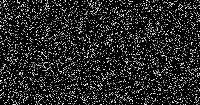

In [6]:
images = np.load('/content/data_shad22_500.npy')

from PIL import Image
print(images.shape)
first_image = Image.fromarray(images[:,:,0].astype('uint8')*255)
display(first_image)

Сначала запустим алгоритмы с рестартами и посмотрим на результат.

In [32]:
F, B, s, A, L_val = run_EM_with_restarts(images, h=100, w=66, max_iter=60, 
                                         use_MAP=True, tolerance=0.0001, n_restarts=5)

 18%|█▊        | 11/60 [01:50<08:13, 10.06s/it]


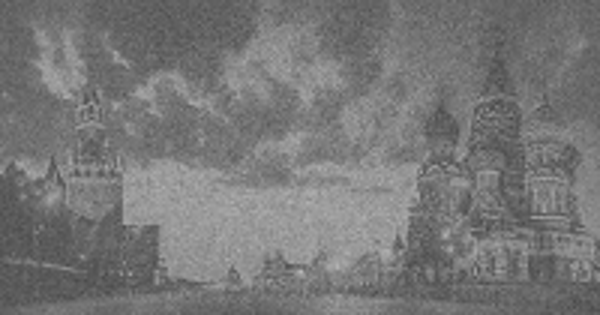

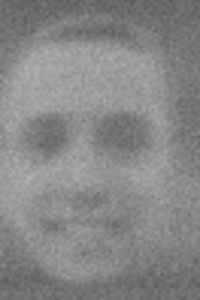

In [33]:
display((Image.fromarray(B.astype('uint8'))).resize((600, 315)))
display((Image.fromarray(F.astype('uint8'))).resize((200, 300)))

In [72]:
F, B, s, A, L_val = run_EM_with_restarts(images, h=100, w=66, max_iter=60, n_restarts=5)

 28%|██▊       | 17/60 [03:55<09:56, 13.88s/it]


In [75]:
len(L_val)

17

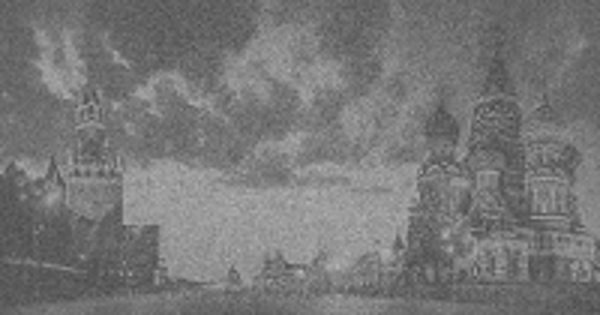

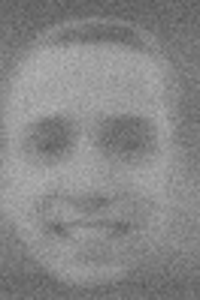

In [73]:
display((Image.fromarray(B.astype('uint8'))).resize((600, 315)))
display((Image.fromarray(F.astype('uint8'))).resize((200, 300)))

Теперь по пунктам

Исходные данные можно видеть в начале ноутбука -- на вид черно-белый шум. Полученные результаты приведены после -- сначала для MAP (чуть более размытые, получены за меньшее число итераций с помощью огрублений q) и затем для не-MAP.


### Пункт 1.
Да, начальное приближение влияет определенно! Когда я запускал hard-EM на фиксированных значениях начальных параметров (как в run_em), получалось ужасно! То есть понятно было, что это лицо, но с рестартами гораздо лучше, см без рестартов:

In [37]:
F, B, s, A, L_val = run_EM(images, h=100, w=66, max_iter=60, tolerance=0.0001, use_MAP=True)

 14%|█▍        | 11/80 [01:40<10:31,  9.15s/it]


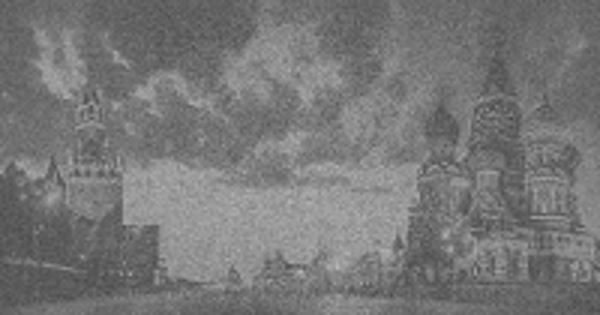

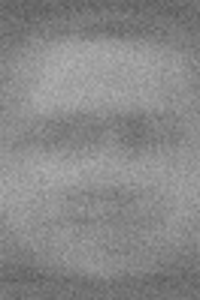

In [43]:
display((Image.fromarray(B.astype('uint8'))).resize((600, 315)))
display((Image.fromarray(F.astype('uint8'))).resize((200, 300)))

Теперь обычный EM без рестартов:

In [45]:
F, B, s, A, L_val = run_EM(images, h=100, w=66, max_iter=60)

100%|██████████| 60/60 [12:06<00:00, 12.11s/it]


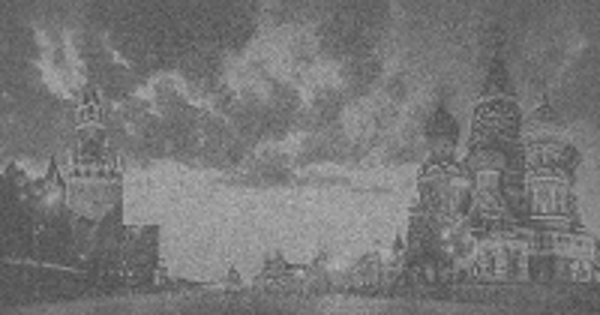

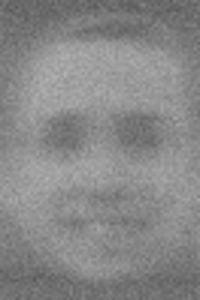

In [47]:
display((Image.fromarray(B.astype('uint8'))).resize((600, 315)))
display((Image.fromarray(F.astype('uint8'))).resize((200, 300)))

Так что да, здесь определенно стоит. Еще можно заметить, что лучшее значение с рестартами EM получено при минимальном количестве итераций, что говорит о решающем значении инициализации.
### Пункт 2.

In [13]:
#@title Генерация технических изображений
def generate_data(H, W, h, w, sigma=0.1, K=100, use_MAP=False, seed=42):
    # explicit data with no noise
    np.random.seed(seed)
    X = np.full((H, W, K), 0.0)
    F = np.full((h, w), 0.1)*255
    B = np.full((H, W), 0.8)*255

    coords = []
    q = np.full((H-h+1, W-w+1, K), 0)
    for k in range(K):
        x = np.random.randint(0, H-h+1)
        y = np.random.randint(0, W-w+1)
        coords.append((x, y))
        X[:, :, k] = np.copy(B)
        X[x:x+h, y:y+w, k] = np.copy(F)
        q[x, y, k] = 1.0

    A = np.random.rand(H - h + 1, W - w + 1)
    A /= A.sum()

    if use_MAP:
        q = np.array(coords).T

    noise = np.random.normal(0, sigma, X.shape) * 255
    X = X + noise

    return X, F, B, A, q

Посмотрим на изображения -- типичный X, затем B и F (для вывода первого изображения я изменил код в генерации данных).

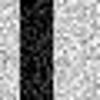

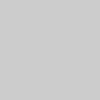

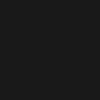

In [72]:
X, F, B, A, q = generate_data(30, 30, 30, 10, sigma=0.1)

display((Image.fromarray((np.clip(X[:, :, 0], 0, 255)).astype('uint8'))).resize((100, 100)))
display((Image.fromarray((B).astype('uint8'))).resize((100, 100)))
display((Image.fromarray((F).astype('uint8'))).resize((100, 100)))

Будем обучать EM на разных выборках.

  4%|▍         | 2/50 [00:03<01:21,  1.70s/it]


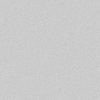

  4%|▍         | 2/50 [00:02<01:02,  1.31s/it]


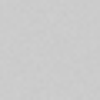

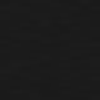

In [94]:
X, F, B, A, q = generate_data(100, 100, 90, 10, sigma=0.1)
F, B, s, A, L_val1 = run_EM(np.clip(X, 0, 255), h=90, w=10)
display((Image.fromarray((B).astype('uint8'))))
display((Image.fromarray((F).astype('uint8'))))

X, F, B, A, q = generate_data(30, 30, 30, 10, K=1000, sigma=0.1)
F, B, s, A, L_val2 = run_EM(np.clip(X,0,255), h=30, w=10) 
display((Image.fromarray(B.astype('uint8'))).resize((100, 100)))
display((Image.fromarray(F.astype('uint8'))).resize((100, 100)))

В этом месте я наткнулся на инициализацию еще раз. При инициализации, при которой значения B были меньше значений F, алгоритм не мог нормально обучиться даже с маленькими сигма и большой выборкой. Долго думал, сменил инициализацию, и оно взлетело как ни в чем не бывало. В целом видно, что при обоих наборах размеров обучается легко и быстро.

In [95]:
L_val1[-1]/X.shape[-1], L_val2[-1]/X.shape[-1]

(-4622.774376185664, -4142.207260188141)

L на меньших задачах уменьшается по модулю -- для задачи с поиском лица преступника L вообще 9-значное (размер выборки был равен 500).

С поиском F и B справляется с такой sigma прилично. Попробуем большее sigma.

  4%|▍         | 2/50 [00:03<01:23,  1.74s/it]


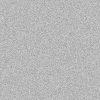

  4%|▍         | 2/50 [00:00<00:04, 10.92it/s]


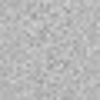

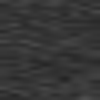

In [92]:
X, F, B, A, q = generate_data(100, 100, 90, 10, sigma=0.4)
F, B, s, A, L_val1 = run_EM(np.clip(X, 0, 255), h=90, w=10)
display((Image.fromarray((B).astype('uint8'))))
display((Image.fromarray((F).astype('uint8'))))

X, F, B, A, q = generate_data(30, 30, 30, 10, sigma=0.4)
F, B, s, A, L_val2 = run_EM(np.clip(X,1,255), h=30, w=10) 
display((Image.fromarray(B.astype('uint8'))).resize((100, 100)))
display((Image.fromarray(F.astype('uint8'))).resize((100, 100)))

In [93]:
L_val1[-1]/X.shape[-1]

-57018.72522695157

Уже видно, что хуже, особенно со вторым примером. L растет по модулю на порядок. Попробуем еще больше.

 14%|█▍        | 7/50 [00:11<01:09,  1.62s/it]


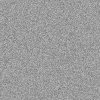

  6%|▌         | 3/50 [00:00<00:04, 11.10it/s]


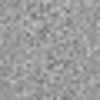

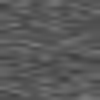

In [90]:
X, F, B, A, q = generate_data(100, 100, 90, 10, sigma=1)
F, B, s, A, L_val1 = run_EM(np.clip(X, 0, 255), h=90, w=10)
display((Image.fromarray((B).astype('uint8'))))
display((Image.fromarray((F).astype('uint8'))))

X, F, B, A, q = generate_data(30, 30, 30, 10, sigma=1)
F, B, s, A, L_val2 = run_EM(np.clip(X,1,255), h=30, w=10) 
display((Image.fromarray(B.astype('uint8'))).resize((100, 100)))
display((Image.fromarray(F.astype('uint8'))).resize((100, 100)))

In [91]:
L_val1[-1]/X.shape[-1]

-60824.70281225169

Этот результат уже можно назвать неудовлетворительным, особенно во втором случае. L примерно то же.

Напоследок попробуем решить с меньшей выборкой.

  4%|▍         | 2/50 [00:00<00:19,  2.48it/s]


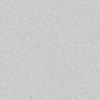

  4%|▍         | 2/50 [00:00<00:01, 33.21it/s]


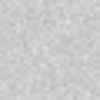

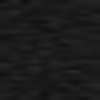

In [96]:
X, F, B, A, q = generate_data(100, 100, 90, 10, K=30, sigma=0.1)
F, B, s, A, L_val1 = run_EM(np.clip(X, 0, 255), h=90, w=10)
display((Image.fromarray((B).astype('uint8'))))
display((Image.fromarray((F).astype('uint8'))))

X, F, B, A, q = generate_data(30, 30, 30, 10, K=30, sigma=0.1)
F, B, s, A, L_val2 = run_EM(np.clip(X,1,255), h=30, w=10) 
display((Image.fromarray(B.astype('uint8'))).resize((100, 100)))
display((Image.fromarray(F.astype('uint8'))).resize((100, 100)))

In [97]:
L_val1[-1]/X.shape[-1]

-46078.33394529274

Хуже, чем с K=100, но все еще прилично. Уменьшим еще.

  4%|▍         | 2/50 [00:00<00:01, 37.57it/s]


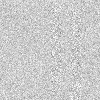

  4%|▍         | 2/50 [00:00<00:00, 186.57it/s]


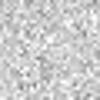

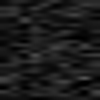

In [98]:
X, F, B, A, q = generate_data(100, 100, 90, 10, K=2, sigma=0.1)
F, B, s, A, L_val1 = run_EM(np.clip(X, 0, 255), h=90, w=10)
display((Image.fromarray((B).astype('uint8'))))
display((Image.fromarray((F).astype('uint8'))))

X, F, B, A, q = generate_data(30, 30, 30, 10, K=2, sigma=0.1)
F, B, s, A, L_val2 = run_EM(np.clip(X,1,255), h=30, w=10) 
display((Image.fromarray(B.astype('uint8'))).resize((100, 100)))
display((Image.fromarray(F.astype('uint8'))).resize((100, 100)))

In [99]:
L_val1[-1]/X.shape[-1]

-42376.67379338622

В общем, значение L само по себе не очень коррелирует с качеством ответа вне границ одного цикла алгоритма (не то чтобы это удивительно).

### Пункт 3

Для счета времени модифицируем генерацию данных, чтобы было сложнее различать B и F.

In [59]:
#@title Генерация технических изображений
def generate_data_b(H, W, h, w, sigma=0.1, K=100, use_MAP=False, seed=42):
    # explicit data with no noise
    np.random.seed(seed)
    X = np.full((H, W, K), 0.0)
    F = np.full((h, w), 0.4)*255 + np.random.normal(0, 0.1, (h,w)) * 255
    B = np.full((H, W), 0.6)*255 + np.random.normal(0, 0.1, X.shape[:2]) * 255

    coords = []
    q = np.full((H-h+1, W-w+1, K), 0)
    for k in range(K):
        x = np.random.randint(0, H-h+1)
        y = np.random.randint(0, W-w+1)
        coords.append((x, y))
        X[:, :, k] = np.copy(B)
        X[x:x+h, y:y+w, k] = np.copy(F)
        q[x, y, k] = 1.0

    A = np.random.rand(H - h + 1, W - w + 1)
    A /= A.sum()

    if use_MAP:
        q = np.array(coords).T

    noise = np.random.normal(0, sigma, X.shape) * 255
    X = X + noise

    return X, F, B, A, q

In [101]:
from time import time
X, F, B, A, q = generate_data_b(300, 300, 70, 20, sigma=0.4)
time0 = time()
F1, B1, s, A, L_val1 = run_EM(np.clip(X, 0, 255), h=70, w=20)
time1 = time()
F2, B2, s, A, L_val2 = run_EM(np.clip(X, 0, 255), h=70, w=20, use_MAP=True)
time2 = time()
print('\n На обычный: ', time1-time0, ', на hard: ', time2-time1)

  6%|▌         | 3/50 [00:14<03:49,  4.87s/it]


 На обычный:  58.89955115318298 , на hard:  14.670737028121948


Hard быстрее, разумеется, поскольку не нужно делать свертки. Аргмаксимум найти гораздо быстрее чем свернуть 2 матрицы -- O от размера (то есть n^2 на размер выборки), в то время как FFT сворачивает пару матриц за O(n^2 log(n)^2) если размер большой матрицы n на n, если не ошибаюсь. На небольших данных это может быть не так заметно (здесь 1 шаг в 3 раза быстрее), но с большими свертками разница растет.

In [102]:
L_val1[-1], L_val2[-1]

(-52259191.84803519, -52259359.00512672)

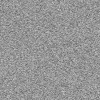

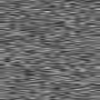

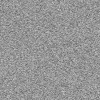

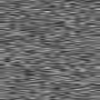

In [67]:
display((Image.fromarray(B1.astype('uint8'))).resize((100, 100)))
display((Image.fromarray(F1.astype('uint8'))).resize((100, 100)))
display((Image.fromarray(B2.astype('uint8'))).resize((100, 100)))
display((Image.fromarray(F2.astype('uint8'))).resize((100, 100)))

А результаты примерно схожи, хоть L в случае не-hard-EM меньше примерно на 200.

### Пункт 4

Ну, этот пункт уже разобран выше, за исключением применения к выборкам разного размера. Давайте применим EM к 50 фото вместо 500.

In [76]:
images_small = images[:,:,:50]
F, B, s, A, L_val = run_EM_with_restarts(images_small, h=100, w=66, max_iter=60, n_restarts=5)

  7%|▋         | 4/60 [00:05<01:13,  1.32s/it]


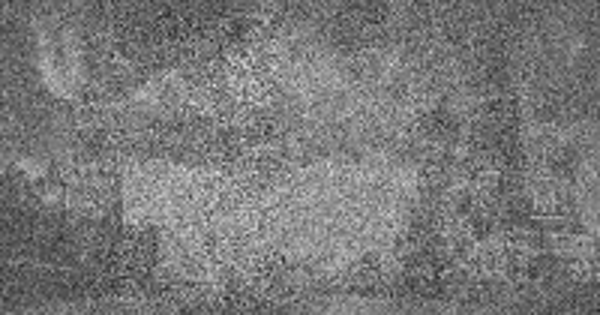

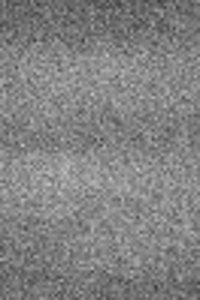

In [77]:
display((Image.fromarray(B.astype('uint8'))).resize((600, 315)))
display((Image.fromarray(F.astype('uint8'))).resize((200, 300)))

Такое. Попробуем больше рестартов.

  5%|▌         | 3/60 [00:04<01:22,  1.45s/it]


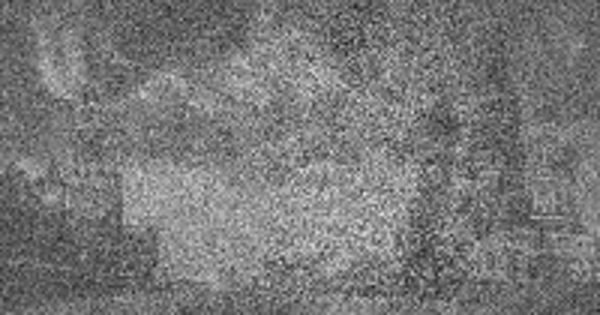

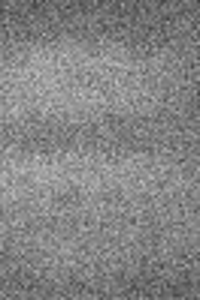

In [78]:
F, B, s, A, L_val = run_EM_with_restarts(images_small, h=100, w=66, max_iter=60, n_restarts=20)
display((Image.fromarray(B.astype('uint8'))).resize((600, 315)))
display((Image.fromarray(F.astype('uint8'))).resize((200, 300)))

Все равно не очень.

### Пункт 5.
Алгоритм, предложенный в условии, кажется довольно естественным. Мне кажется, его можно сильно ускроить, не сильно при этом потеряв: вместо того чтобы сворачивать со всеми значениями q, можно выбрать top_k значений d для каждого X_k и взвешивать ими значения X. При k=1 получаем модификацию hard-EM, предложенную в условии. Кажется, что если выбрать k=10, алгоритм по тем же причинам будет все еще заметно быстрее (нет сверток), в то же время результат будет отличаться несильно, особенно после первых шагов, когда вероятности начинают расходиться к нулю и единице, и сумма условных десяти максимальных значений q (при фиксированном изображении) очень близка к 1. 

Вторая идея для ускорения алгоритма из условия -- считать вероятности, в которых присутствуют свретки, в 2 этапа. На первом этапе вместо обычной свертки мы считаем сверку лишь с частью F --- с четвертью, скажем -- это тоже проверка схожести F и части изображения, то есть правдоподобность такого d. После этого у нас появляется представление о том, какие вероятности на порядки больше других. Их мы досчитываем как подобает, а остальные считаем нулевыми.

Наконец, приходит идея о ином подходе. Если усреднить все изображения (штук 100 хотя бы), шум по ЗБЧ уйдет. Можно попробовать суммировать подмножества изображений и обучать скрытые переменные, отвечающие за присутствие слагаемого в сумме. Не знаю, будет ли это лучше -- но идея в том, чтобы убить шум. 